In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import pystan

import matplotlib.pyplot as plt

In [2]:
plt.style.context('seaborn')

In [3]:
df = pd.read_csv('weekly_in_situ_co2_mlo.csv', header=None, parse_dates=[0], dtype={1: np.float16}, names=['date', 'level_ppm'])
df.head()

,date,level_ppm
0,1958-03-29,316.25
1,1958-04-05,317.25
2,1958-04-12,317.75
3,1958-04-19,317.50
4,1958-04-26,316.50


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3210 entries, 0 to 3209
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       3210 non-null   datetime64[ns]
 1   level_ppm  3210 non-null   float16       
dtypes: datetime64[ns](1), float16(1)
memory usage: 31.5 KB


<AxesSubplot:xlabel='date'>

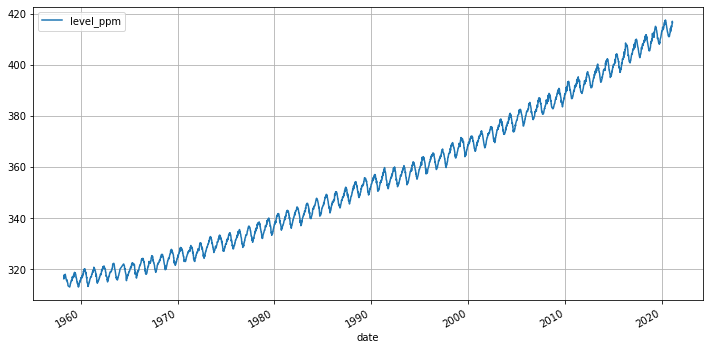

In [5]:
df.plot('date', 'level_ppm', figsize=(12, 6), grid=True)

In [6]:
df['timestamp'] = df['date'].apply(datetime.timestamp)
df.head()

,date,level_ppm,timestamp
0,1958-03-29,316.25,-371185200.0
1,1958-04-05,317.25,-370580400.0
2,1958-04-12,317.75,-369975600.0
3,1958-04-19,317.50,-369370800.0
4,1958-04-26,316.50,-368766000.0


In [7]:
bad_stan_model = pystan.StanModel(file='bad_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3eda933426b4443994ceaaadf61b16a1 NOW.


In [8]:
stan_data = {
    'N': len(df),
    'y': df['level_ppm'],
    'x': df['timestamp']
}
bad_results = bad_stan_model.sampling(data=stan_data)
print(bad_results)

Inference for Stan model: anon_model_3eda933426b4443994ceaaadf61b16a1.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean      sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0   324.36  2.5e-3    0.12 324.13 324.28 324.36 324.45 324.59   2202    1.0
c1   5.0e-8 2.8e-12 1.4e-10 5.0e-8 5.0e-8 5.0e-8 5.1e-8 5.1e-8   2528    1.0
s      4.47  1.3e-3    0.06   4.36   4.43   4.47   4.51   4.58   1979    1.0
lp__  -6426    0.03    1.21  -6429  -6427  -6426  -6425  -6425   1493    1.0

Samples were drawn using NUTS at Thu Apr 22 01:03:37 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [9]:
bad_results['c1'][0]

5.031057863013309e-08

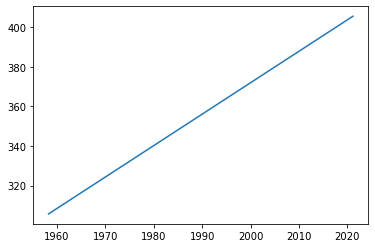

In [10]:
plt.plot(df['date'], df['timestamp'] * bad_results['c1'][0] + bad_results['c0'][0])

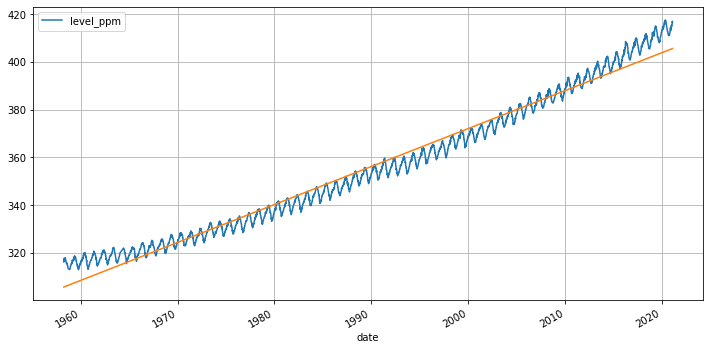

In [11]:
df.plot('date', 'level_ppm', figsize=(12, 6), grid=True)
plt.plot(df['date'], df['timestamp'] * bad_results['c1'][0] + bad_results['c0'][0])